In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
transactions_csv = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")

In [3]:
!pip uninstall -y scikit-learn imbalanced-learn
!pip install scikit-learn==1.3.2
!pip install imbalanced-learn==0.11.0

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 72.8 MB/s eta 0:00:00:00:01:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.3.2 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 4.9 MB/s eta 0:00:0000:01


In [4]:
identity_csv = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")

transactions_csv = transactions_csv.merge(identity_csv, on='TransactionID', how='left')

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import shap


X = transactions_csv.drop(columns=["isFraud"])
y = transactions_csv["isFraud"]

user_proxy = (
    X['card1'].astype(str) + '_' +
    X['addr1'].astype(str) + '_' +
    X['P_emaildomain'].astype(str)
)

# First split: 80% train+val, 20% test
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(gss.split(X, y, groups=user_proxy))

X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
user_proxy_train_val = user_proxy.iloc[train_val_idx]

# Second split: 75% train, 25% validation
gss_val = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, val_idx = next(gss_val.split(X_train_val, y_train_val, groups=user_proxy_train_val))

X_train = X_train_val.iloc[train_idx]
X_val = X_train_val.iloc[val_idx]
y_train = y_train_val.iloc[train_idx]
y_val = y_train_val.iloc[val_idx]

X_train = X_train.drop(columns=["TransactionID"])
X_val = X_val.drop(columns=["TransactionID"])
X_test = X_test.drop(columns=["TransactionID"])

X_train_saved = X_train.copy()
X_val_saved = X_val.copy()
X_test_saved = X_test.copy()

In [6]:
!pip install dagshub mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 6.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 56.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 80.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installe

In [7]:
import dagshub 
import mlflow
dagshub.init(repo_owner='Luka-Surmanidze', repo_name='IEEE-CIS-Fraud-Detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=3494a0f6-d783-44d5-bf3f-af7f7f97fc07&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=8b7103ae63aa87221fcfbf627ff82ecdb90cd9b8ae1a4aff96fbaa0fe3ab637f




Accessing as Luka-Surmanidze

Initialized MLflow to track repo "Luka-Surmanidze/IEEE-CIS-Fraud-Detection"

Repository Luka-Surmanidze/IEEE-CIS-Fraud-Detection initialized!

In [21]:
# experiment_name = "XGBoost"

In [22]:
# mlflow.set_experiment(experiment_name)

2025/04/27 18:08:15 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1b389494c76e454d99483ed1ac24a69c', creation_time=1745777295654, experiment_id='3', last_update_time=1745777295654, lifecycle_stage='active', name='XGBoost', tags={}>

In [8]:
import mlflow
logged_model = 'runs:/44da463e971c43b4a8b27ee2eeb486e4/cleaning_pipeline'

# Load model
cleaning_pipeline = mlflow.sklearn.load_model(logged_model)

In [23]:
# run_name = "XGBoost_cleaningV1"

# mlflow.end_run()
# mlflow.start_run(run_name=run_name)

# mlflow.log_param("Part", "Cleaning")
# mlflow.log_param("Na columns default impute method", "ModeImputing")
# mlflow.log_param("Dropping NA columns default threshold", 0.8)

# mlflow.sklearn.log_model(cleaning_pipeline, "cleaning_pipeline")
# mlflow.end_run()

2025/04/27 18:08:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/27 18:08:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_cleaningV1 at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/3/runs/852f97dfbf2843fa8a0a7f3d54d02516
🧪 View experiment at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/3


In [9]:
import mlflow
logged_model = 'runs:/88d53b77e45247fabe761ca574d0ac2f/engineering_pipeline'

# Load model
engineering_pipeline = mlflow.sklearn.load_model(logged_model)

In [24]:
# run_name = "XGBoost_engineeringV1"

# mlflow.end_run()
# mlflow.start_run(run_name=run_name)

# mlflow.log_param("Part", "Feature Engineering")
# mlflow.log_param("categorical_encoding_technique_1", "woe_encoding")
# mlflow.log_param("categorical_encoding_technique_2", "one_hot_encoding")

# mlflow.log_param("default_threshold_for_one_hot_cols", 3)

# mlflow.sklearn.log_model(engineering_pipeline, "engineering_pipeline")
# mlflow.end_run()

2025/04/27 18:08:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/27 18:08:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_engineeringV1 at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/3/runs/a2e3e008c1fd420eaea190f2294df421
🧪 View experiment at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/3


In [10]:
import mlflow
logged_model = 'runs:/deb1082842fe448385975a7de1f4e99b/selection_pipeline'

# Load model
selection_pipeline = mlflow.sklearn.load_model(logged_model)

In [25]:
# run_name = "XGBoost_selectionV1"

# mlflow.end_run()
# mlflow.start_run(run_name=run_name)

# mlflow.log_param("Part", "Feature Selection")
# mlflow.log_param("default_corr_threshold", 0.9)
# mlflow.log_param("highly_correlated_pairs_size", 146)

# mlflow.log_param("low_variance_features_size", 24)

# mlflow.log_param("selection_technique_0", "not_using_selection_at_all(passthrough)")

# mlflow.log_param("selection_technique_1", "finding_highly_correlated_features")

# mlflow.log_param("selection_technique_2", "finding_low_variance_remaining_features")


# mlflow.log_param("default_low_variance_threshold", 0.01)

# mlflow.sklearn.log_model(selection_pipeline, "selection_pipeline")
# mlflow.end_run()

2025/04/27 18:09:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/27 18:09:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_selectionV1 at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/3/runs/dd8612ea017c48468a8aeb7e3e86f28e
🧪 View experiment at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/3


In [11]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score
import numpy as np
from itertools import product


def evaluate_model(pipeline_steps, params, X_train, y_train, X_val, y_val):
    pipeline = ImbPipeline(pipeline_steps)
    
    pipeline.set_params(**params)
    
    pipeline.fit(X_train, y_train)
    
    y_val_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    val_score = roc_auc_score(y_val, y_val_pred_proba)
    
    return val_score, pipeline

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)

In [13]:
na_cols_to_drop = ['V180', 'V299', 'V15', 'V178', 'V269', 'V264', 'V127', 'V168', 'V57', 'V306', 'V59', 
                   'V318', 'V51', 'V255', 'V246', 'V16', 'V179', 'V307', 'V21', 'V69', 'V167', 'V29', 'V204', 
                   'V101', 'V54', 'V259', 'V237', 'V211', 'V193', 'V231', 'V4', 'V274', 'V64', 'V195', 'V242', 
                   'V133', 'V272', 'V94', 'V19', 'V92', 'V319', 'V132', 'V27', 'V270', 'V308', 'V177', 'V313', 
                   'V36', 'V72', 'V39', 'V106', 'V316', 'V232', 'V278', 'V80', 'V190', 'V213', 'V253', 'V200', 
                   'V293', 'V291', 'V192', 'V32', 'V76', 'V113', 'V102', 'V221', 'C10', 'V202', 'C1', 'V134', 
                   'V275', 'V294', 'D1', 'V321', 'C11', 'V273', 'V71', 'V13', 'V304', 'id_29_NotFound', 'V303', 'C14', 
                   'V238', 'V105', 'V17', 'V298', 'V317', 'V176', 'C5', 'C8', 'V212', 'V84', 'V31', 
                   'V93', 'V248', 'V233', 'V203', 'V254', 'V280', 'V182', 'V251', 'V128', 'V11', 'V70', 'V34', 'V297', 
                   'V30', 'V216', 'V263', 'V103', 'V91', 'V97', 'V73', 'V126', 'V183', 'V49', 'V236', 'V245', 
                   'id_17', 'V60', 'V129', 'C6', 'C4','V219', 'V42', 'V196', 'V224', 'V22', 'id_16_NotFound', 'V300', 
                   'V217', 'V194', 'C7', 'V229', 'C12', 'V276', 'V279', 'V44', 'V296', 'V50', 'V58', 'V33', 'V95', 
                   'V206', 'V295', 'V186', 'V104', 'V137', 'V1', 'V14', 'V28', 'V41', 'V65', 'V68', 'V88', 'V89', 'V107', 'V108',
       'V110', 'V111', 'V112', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122',
       'V240', 'V241', 'V305', 'card4_woe', 'M1_T']

In [14]:
preprocess = [cleaning_pipeline, engineering_pipeline, selection_pipeline]

preprocess_steps = []
for p in preprocess:
    for step in p:
        preprocess_steps.append(step)

preprocess_steps

named_preprocess_steps = [
    ('na_cols_dropper', preprocess_steps[0]), 
    ('na_cols_mode_imputer', preprocess_steps[1]),
    ('CategoricalPreprocessor', preprocess_steps[2]),
    ('cleaner', 'passthrough')
]

In [15]:
from xgboost import XGBClassifier

pipeline = ImbPipeline([
    *named_preprocess_steps,
    ('sampler', 'passthrough'),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='auc'))
])

pipeline.steps

[('na_cols_dropper',
  ColumnDropper(columns_to_drop=Index(['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139',
         'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148',
         'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157',
         'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166',
         'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330',
         'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339',
         'id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10', 'id_14', 'id_18',
         'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30',
         'id_32', 'id_33', 'id_34'],
        dtype='object'))),
 ('na_cols_mode_imputer', ModeImputer()),
 ('CategoricalPreprocessor',
  CategoricalPreprocessor(one_hot_columns=['M1', 'M2', 'M3', 'M4', 'M5', 'M6',
                                           'M7', 'M8', 'M9', 'id_12', 'id_15',
          

In [43]:
X_train['dist2']

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
590535   NaN
590536   NaN
590537   NaN
590538   NaN
590539   NaN
Name: dist2, Length: 358445, dtype: float64

In [17]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

pipeline_steps = pipeline.steps

print(pipeline_steps)

param_grid = {
    'cleaner': [
        'passthrough', 
                ColumnDropper(na_cols_to_drop)
    ],
    'sampler': [
        'passthrough',
        RandomOverSampler(random_state=42, sampling_strategy=0.2)
        ,
        RandomUnderSampler(random_state=42, sampling_strategy=0.2)
        ,
        SMOTE(random_state=42, sampling_strategy=0.2)
    ],
    'classifier__n_estimators': [
        200, 
        250],         
    'classifier__max_depth': [
        4, 
        6],                
    'classifier__learning_rate': [0.1
                                  ,  0.01
                                 ],       
    'classifier__min_child_weight': [1
                                     , 3
                                    ]             
    
}

param_names = list(param_grid.keys())
param_values = list(param_grid.values())
param_combinations = list(product(*param_values))

# Store results
results = []

# Evaluate each combination
print("Starting grid search with predefined validation set...")
for i, combo in enumerate(param_combinations):
    # Create parameter dictionary
    params = {name: value for name, value in zip(param_names, combo)}
    
    # Print progress
    print(f"Evaluating combination {i+1}/{len(param_combinations)}: {params}")
    
    # Evaluate
    val_score, fitted_pipeline = evaluate_model(
        pipeline_steps, params, X_train_saved, y_train, X_val_saved, y_val
    )
    
    # Store results
    results.append({
        'params': params,
        'val_score': val_score,
        'pipeline': fitted_pipeline
    })
    
    print(f"Validation ROC AUC: {val_score:.4f}")
    print("-" * 50)

# Find best model
best_result = max(results, key=lambda x: x['val_score'])
best_params = best_result['params']
best_score = best_result['val_score']
best_model = best_result['pipeline']

print("\nBest parameters:", best_params)
print("Best validation score:", best_score)

[('na_cols_dropper', ColumnDropper(columns_to_drop=Index(['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139',
       'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148',
       'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157',
       'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166',
       'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330',
       'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339',
       'id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10', 'id_14', 'id_18',
       'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30',
       'id_32', 'id_33', 'id_34'],
      dtype='object'))), ('na_cols_mode_imputer', ModeImputer()), ('CategoricalPreprocessor', CategoricalPreprocessor(one_hot_columns=['M1', 'M2', 'M3', 'M4', 'M5', 'M6',
                                         'M7', 'M8', 'M9', 'id_12', 'id_15',
                                    

In [18]:
pipeline = ImbPipeline(pipeline_steps)
    
    # Set parameters
pipeline.set_params(**best_params)
    
    # Train the model
best_model = pipeline.fit(X_train, y_train)

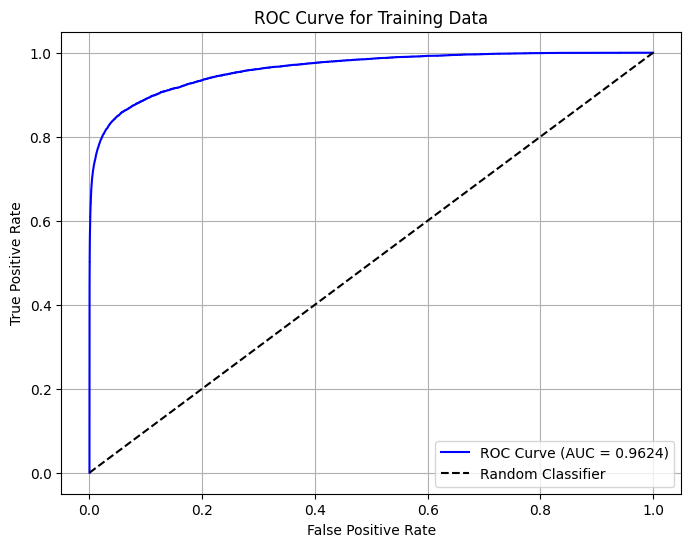

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


y_train_proba = best_model.predict_proba(X_train_saved)[:, 1]

# Calculate ROC values using y_train (not y_test)
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba)  # Use y_train here
auc = roc_auc_score(y_train, y_train_proba)  # Use y_train here too

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data')
plt.legend()
plt.grid(True)
plt.show()

found dash index - 5
found dash index - 10


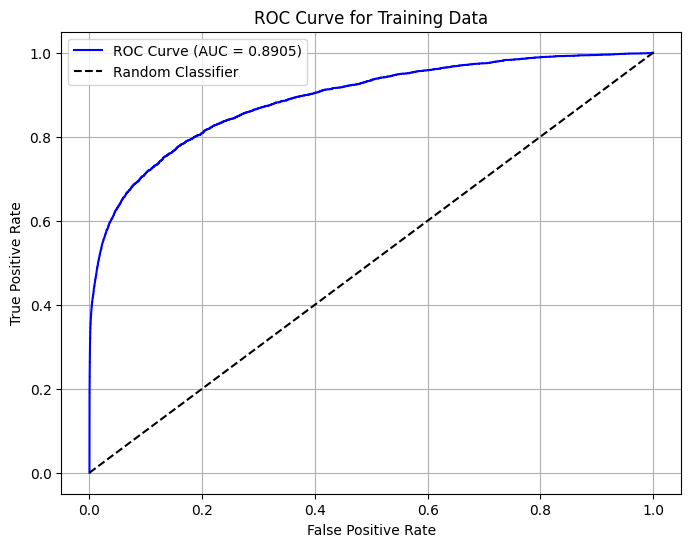

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities on training data
y_test_proba = best_model.predict_proba(X_test_saved)[:, 1]

# Calculate ROC values using y_train (not y_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)  # Use y_train here
auc = roc_auc_score(y_test, y_test_proba)  # Use y_train here too

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# run_name = "XGboost_trainingV1"


# mlflow.end_run()
# mlflow.start_run(run_name=run_name)

# mlflow.log_param("Part", "Training")
# mlflow.log_param("random_seed", 42)
# mlflow.log_param("best_model_sampler", "RandomOverSampler")

# mlflow.log_param("best_model_n_estimators", 250)
# mlflow.log_param("best_model_max_depth", 6)
# mlflow.log_param("classifier__learning_rate", 0.1)
# mlflow.log_param("classifier__min_child_weight", 1)

# mlflow.log_param("RandomOverSamplerStrategy", 0.2)

# mlflow.log_metric("validation_roc_auc_score", 0.90)

# mlflow.log_metric("train_roc_auc_score", 0.96)

# mlflow.log_metric("test_roc_auc_score", 0.89)

# mlflow.sklearn.log_model(best_model, "XGboost_trainingV1")

# mlflow.end_run()

2025/04/27 18:11:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGboost_trainingV1 at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/3/runs/07196e00dfe141b7a3d43050cca2e984
🧪 View experiment at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/3
